In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from scipy.stats import gamma, uniform
import seaborn as sns
import os

plt.style.use('seaborn')


# Methods for exporting tables and images to latex
def saveimg(filename, fig):
    file_path = os.path.join(os.getcwd(), 'images')
    os.makedirs(file_path, exist_ok=True)
    fig.savefig(os.path.join(file_path, filename))
    
def savetable(filename, df):
    file_path = os.path.join(os.getcwd(), 'tables')
    os.makedirs(file_path, exist_ok=True)
    pd.DataFrame(df).to_latex(os.path.join(file_path, filename),escape = False, index = False)

In [256]:
disasters = genfromtxt('disasters.csv', delimiter = ',')

#Calculate transition probability, based on random walk proposal
def calc_probability_random_walk(tau, breakpoints_current, breakpoints_propose, labda):
    
    # Check if sorted
    if np.all(breakpoints_propose[:-1] <= breakpoints_propose[1:]):
        
        nt_current = np.histogram(tau, bins = breakpoints_current)[0].astype('int32')
        nt_propose = np.histogram(tau, bins = breakpoints_propose)[0].astype('int32')
        
        log_prob_current = (- np.sum(labda*np.diff(breakpoints_current)) 
                            + np.sum(nt_current*np.log(labda)))
        
        log_prob_propose = (-np.sum(labda*np.diff(breakpoints_propose)) 
                            + np.sum(nt_propose*np.log(labda)))
               
        return np.minimum(1, np.exp(log_prob_propose - log_prob_current))
    
    else:
        return 0 
    
#Propose moving one single breakpoint
def proposal_random_walk(breakpoints, index, rho):
    
    ti = breakpoints[index]
    R = rho*(breakpoints[index+1] - breakpoints[index-1])
    epsilon = np.random.uniform(-R, R)
    ti_proposal = ti + epsilon
    
    return ti_proposal

def sample_lambdas(tau, theta, breakpoints, num_breakpoints):
    
    nt_current = np.histogram(tau, bins = breakpoints)[0].astype('int32')
    diff = np.diff(breakpoints)
    
    sample_lambda = lambda i: np.random.gamma(2 + nt_current[i], 1/(theta + diff[i]))
    
    lambdas = np.apply_along_axis(sample_lambda, 0, np.arange(0, num_breakpoints + 1))
    
    return lambdas
    
def sample_theta(psi, labdas, num_breakpoints):
    
    theta = np.random.gamma(2 + 2*(num_breakpoints + 1), 1/(psi + np.sum(labdas)))
    
    return theta
    
    
def init_mcmc(N, num_breakpoints, psi, rho, burn_in = 0, print_debug = False):
    
    #Initial burn in attempts if needed
    M = N + burn_in
    
    #Initialize arrays
    breakpoints = np.zeros((M, num_breakpoints + 2))
    breakpoints[0] = np.arange(1658,1981, (1980-1658)/(num_breakpoints+1))
    tau = disasters  

    #Arrays to save values of lambda and theta
    lambdas = np.zeros((M, num_breakpoints + 1))
    thetas = np.zeros(M)
    
    #Array to save MH probability
    probs = np.zeros(M)
    accepts = np.zeros(M)
    
    #Initialize theta and lambda by prior distribution
    thetas[0] = np.random.gamma(2, 1/psi)
    
    for interval in range(num_breakpoints + 1):
        lambdas[0, interval] = np.random.gamma(2, 1/thetas[0])
    
    #Main loop
    for index in range(M - 1):
        
        #Gibbs sampling
        thetas[index + 1] = sample_theta(psi, lambdas[index], num_breakpoints)
        lambdas[index + 1] = sample_lambdas(tau, thetas[index + 1], breakpoints[index], num_breakpoints)

        
        #Random walk proposal for breakpoints (MH Sampling)
        breakpoints_propose = np.copy(breakpoints[index])
        
        #Propose one breakpoint at a time
        for t in np.arange(num_breakpoints) + 1:
            
            #Propose new breakpoint
            breakpoints_propose[t] = proposal_random_walk(breakpoints[index], t, rho)

        #Probability of accept
        probs[index] = calc_probability_random_walk(tau, breakpoints[index], breakpoints_propose, lambdas[index + 1])

        accept = np.random.uniform(0,1) < probs[index]
        accepts[index] = accept

        if print_debug:
            print(f'Iter: {index}')
            print(f' Theta: {thetas[index]}')
            print(f' Lambda: {lambdas[index]}')
            print(f'Breakpoint {t}')
            print(f' Current breakpoints: {breakpoints[index]}')
            print(f' Proposed breakpoints: {breakpoints_propose}')
            print(f' P(accept) = {probs[index]}')
            print(f' Accept: {accept}')
            print('____________________________________________________________')

        if accept:
            breakpoints[index + 1] = np.copy(breakpoints_propose)
        else:
            breakpoints[index+1] = np.copy(breakpoints[index])

    return breakpoints[burn_in:], thetas[burn_in:], lambdas[burn_in:], probs[burn_in:], accepts[burn_in:]
    

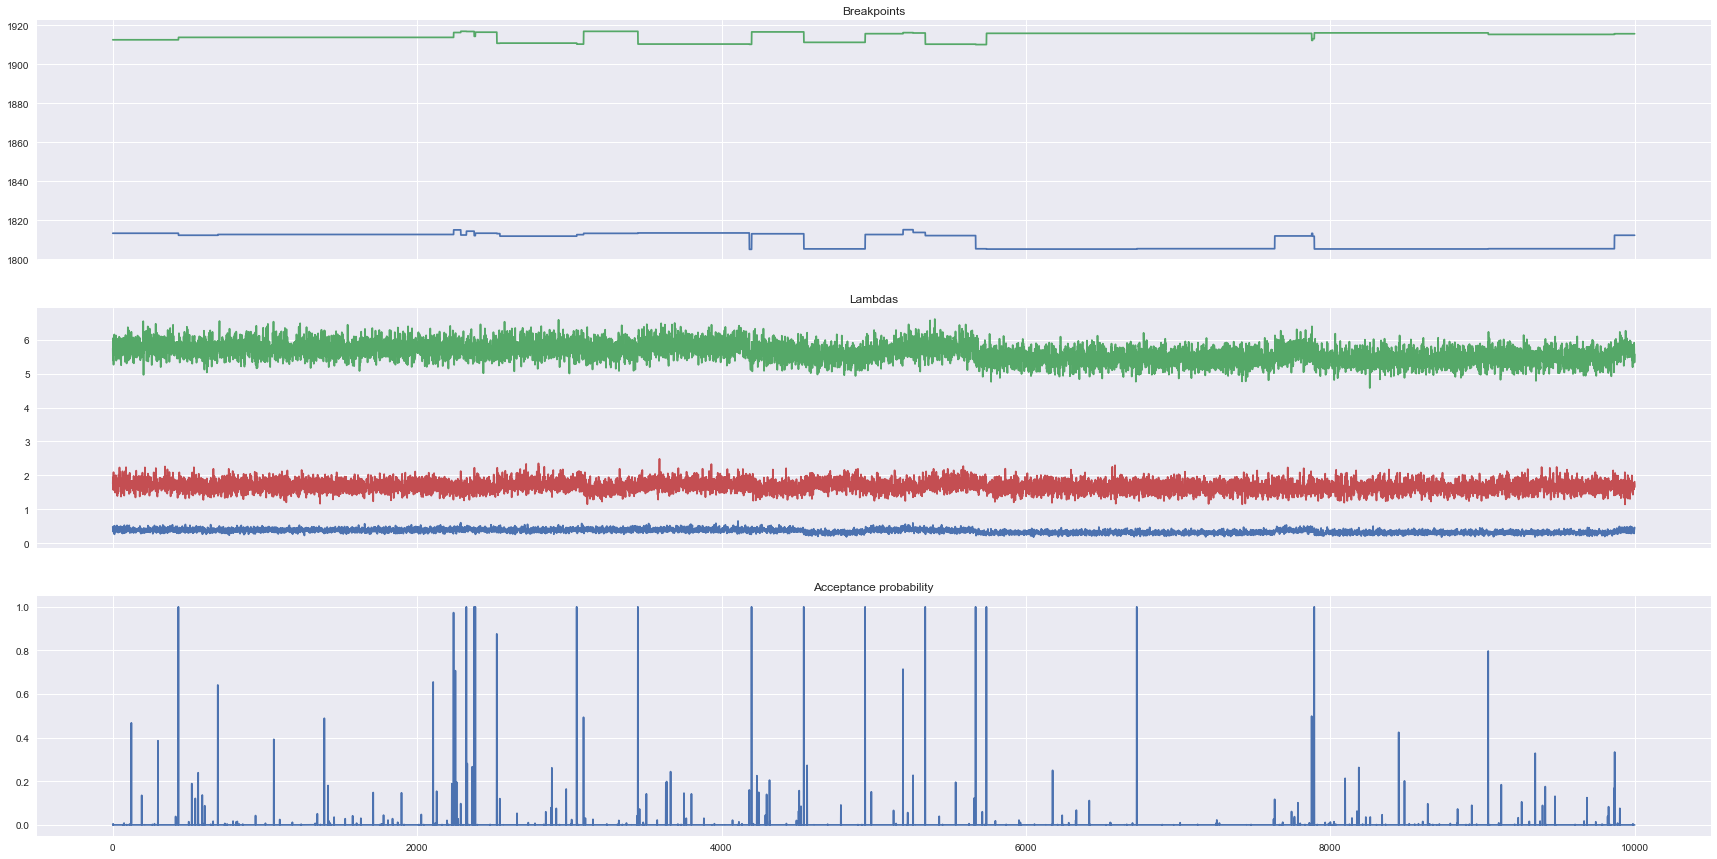

In [260]:
breakpoints, thetas, lambdas, probs, accepts = init_mcmc(N = 10**4, num_breakpoints = 2, psi = 7, rho = 0.1 ,burn_in = 200, print_debug = False)
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (30,15), sharex = True)
ax1.plot(breakpoints[:, 1:-1])
ax1.set_title("Breakpoints")
ax2.plot(lambdas)
ax2.set_title("Lambdas")
ax3.plot(probs)
ax3.set_title("Acceptance probability")
plt.show()

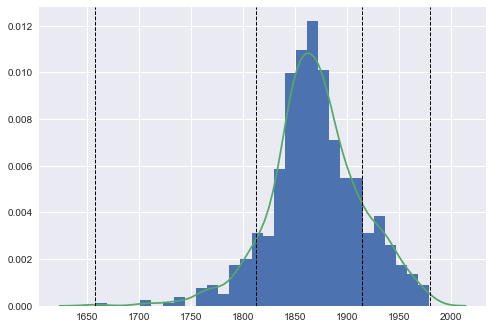

In [252]:
plt.hist(disasters, bins = 'auto', density  = True)
sns.distplot(disasters, hist = False)
for breakpoint in breakpoints[-1]:
    plt.axvline(breakpoint, color='k', linestyle='dashed', linewidth=1)


In [237]:
np.sum(accepts)/len(accepts)

0.0049

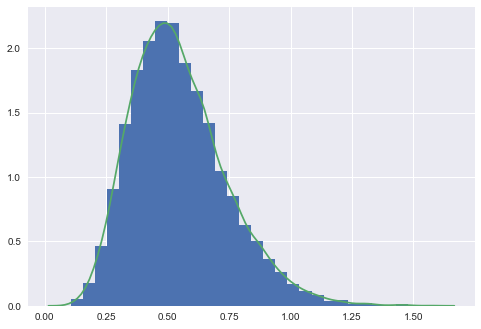

In [261]:
plt.hist(thetas, bins = 30, density = True)
sns.distplot(thetas, hist = False)

In [234]:
lambdas[:,0]

array([0.2011436 , 0.22329961, 0.20099988, 0.21658764, 0.12566102,
       0.18615961, 0.21002561, 0.23857873, 0.17368243, 0.21544461,
       0.24029026, 0.24835309, 0.18559995, 0.17277151, 0.18936775,
       0.20121312, 0.16422707, 0.26973268, 0.1773546 , 0.19868934,
       0.23937738, 0.22913003, 0.20154572, 0.21586226, 0.22355525,
       0.18598879, 0.15433135, 0.21109181, 0.15641107, 0.22190958,
       0.22442479, 0.29720282, 0.26605097, 0.25485174, 0.20094018,
       0.17159109, 0.20907645, 0.19594048, 0.31626452, 0.2513001 ,
       0.24199532, 0.22864768, 0.20361991, 0.25947488, 0.23138852,
       0.20191368, 0.23768734, 0.21822634, 0.24170447, 0.21239585,
       0.24083783, 0.20908789, 0.20009257, 0.20361875, 0.20303371,
       0.22721011, 0.1967093 , 0.27569325, 0.22920242, 0.31838106,
       0.26224012, 0.26379159, 0.2172431 , 0.23062869, 0.31838027,
       0.21316668, 0.20410629, 0.22486616, 0.21803662, 0.2217197 ,
       0.21386677, 0.2446096 , 0.22498601, 0.21610018, 0.17600

In [94]:
a = np.array([1, 2, 3, 4, 5])

a1 = a[1:]
a2 = a[:-1]

In [95]:
np.all(a2 >= a1)

False

In [ ]:
a2